## 1. Carga de datos

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

In [57]:

print('Cargando los datos...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=50000)

Cargando los datos...


In [145]:
start_char = 1
oov_char = 2
index_from = 3

word_index = tf.keras.datasets.imdb.get_word_index()
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"


In [147]:
for i in range(10):
    decoded = " ".join(inverted_word_index[j] if inverted_word_index[j] else "[OOV]" for j in X_train[i])
    print(decoded)

that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all
off their stomachs sickening that men actually wore them and the music is just synthesiser trash that plays over and over again in almost every scene there is trashy music boobs and paramedics taking away bodies and the gym still doesn't close for bereavement all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then
started talking to each other leaving or generally crying into their popcorn that they actually paid money they had earnt working to watch this feeble ex

KeyError: 0

## 2. Limpieza y extraccion de caractersiticas
Las caracteristicas principales que se extrajeron fue la longitud de las criticas, la proporcion de palbras negativas y positivas. Estas palabras se determinan por un 

In [59]:
import nltk
nltk.download('opinion_lexicon')
nltk.download('punkt')
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize

# Load word lists
pos_words = set(opinion_lexicon.positive())
neg_words = set(opinion_lexicon.negative())

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\JM\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [61]:
print(len(pos_words))
print(len(neg_words))

2006
4783


In [62]:
import numpy as np

def get_features(entry):
    n = len(entry)
    decoded = [inverted_word_index[j] for j in entry if j in inverted_word_index]

    pos_count = sum(w in pos_words for w in decoded)
    neg_count = sum(w in neg_words for w in decoded)
        
    
    return [n, pos_count/n, neg_count/n]
    
        
X_extra_train = np.array([get_features(
    entry
) for entry in X_train])    

X_extra_test = np.array([get_features(
    entry
) for entry in X_test])    


In [63]:
X_train = sequence.pad_sequences(X_train, maxlen = 80)
X_test = sequence.pad_sequences(X_test, maxlen = 80)

In [64]:
midpoint = len(X_test)//2
X_val = X_test[:midpoint]
X_extra_val = X_extra_test[:midpoint]
y_val = y_test[:midpoint]

In [65]:
print(f"Train: {X_train.shape} + {X_extra_train.shape} -> {y_train.shape}")
print(f"Val: {X_val.shape} + {X_extra_val.shape} -> {y_val.shape}")
print(f"Test: {X_test.shape} + {X_extra_test.shape} -> {y_test.shape}")

Train: (25000, 80) + (25000, 3) -> (25000,)
Val: (12500, 80) + (12500, 3) -> (12500,)
Test: (25000, 80) + (25000, 3) -> (25000,)


## Model

In [200]:
from tensorflow.keras.layers import Dropout, Attention, GlobalAveragePooling1D, Concatenate, Multiply, Add, Bidirectional
from tensorflow.keras import Input, Model, regularizers

# Entrada de secuencia
sequence_in = Input(shape=(None,))
# Embedding
x = Embedding(50000,16)(sequence_in)
# LSTM
x = Bidirectional(LSTM(16, dropout=0.3, recurrent_dropout=0.3,
            kernel_regularizer=regularizers.l2(1e-2),
            return_sequences=True))(x)

# Self Attention
attention = Attention()([x,x])
# Dense
x = GlobalAveragePooling1D()(attention)
x = Dense(32, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.4)(x)
# Extra features
extra_in = Input(shape=(3,))
y = Dense(4, activation="relu", kernel_initializer='he_normal')(extra_in)
y = Dropout(0.2)(y) 

# Output
combined = Concatenate()([x,y])
combined = Dropout(0.2)(combined)

outputs = Dense(1, activation='sigmoid')(combined)

# Model definition
modelo_nuevo = Model(inputs=[sequence_in, extra_in], outputs=outputs)
modelo_nuevo.summary()


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_80      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_40        │ (None, None, 16)  │    800,000 │ input_layer_80[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_24    │ (None, None, 32)  │      4,224 │ embedding_40[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_40        │ (None, None, 32)  │          0 │ bidirectional_24… │
│ (Attention)         │                   │            │ bidirectional_24… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ attention_40[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_81      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_152 (Dense)   │ (None, 32)        │      1,056 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_153 (Dense)   │ (None, 4)         │         16 │ input_layer_81[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_86          │ (None, 32)        │          0 │ dense_152[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_87          │ (None, 4)         │          0 │ dense_153[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 36)        │          0 │ dropout_86[0][0], │
│ (Concatenate)       │                   │            │ dropout_87[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_88          │ (None, 36)        │          0 │ concatenate_11[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_154 (Dense)   │ (None, 1)         │         37 │ dropout_88[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 805,333 (3.07 MB)

 Trainable params: 805,333 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

In [193]:
modelo_nuevo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [194]:
print("---- Modelo Nuevo ----\n")
historia_new = modelo_nuevo.fit(
    [X_train, X_extra_train], 
    y_train,
    batch_size = 64, 
    epochs = 4,
    verbose = 1,     
    validation_data = ([X_val, X_extra_val], y_val)
)

---- Modelo Nuevo ----

Epoch 1/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 66s 153ms/step - accuracy: 0.5026 - loss: 23.7931 - val_accuracy: 0.7482 - val_loss: 1.1778
Epoch 2/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 66s 168ms/step - accuracy: 0.7053 - loss: 1.7014 - val_accuracy: 0.8001 - val_loss: 0.4735
Epoch 3/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 67s 171ms/step - accuracy: 0.8525 - loss: 0.3977 - val_accuracy: 0.8242 - val_loss: 0.4133
Epoch 4/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 57s 145ms/step - accuracy: 0.8953 - loss: 0.3116 - val_accuracy: 0.8325 - val_loss: 0.3992


## Evaluacion

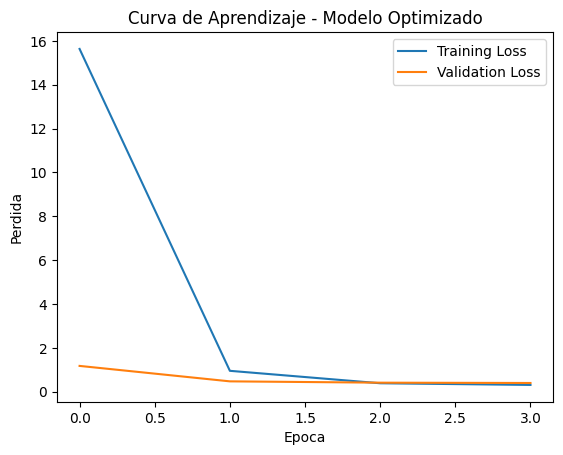

In [195]:
from matplotlib import pyplot as plt
import numpy as np

plt.title("Curva de Aprendizaje - Modelo Optimizado")
plt.plot(np.arange(0,4), historia_new.history["loss"], label="Training Loss")
plt.plot(np.arange(0,4), historia_new.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoca")
plt.ylabel("Perdida")
plt.legend()
plt.show()

In [109]:
print(type(X_test), type(X_extra_test))
print(X_test.shape, X_extra_test.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(25000, 80) (25000, 3)


In [196]:
loss, acc = modelo_nuevo.evaluate(
    [X_test, X_extra_test], 
    y_test,
    batch_size = 64,
    verbose = 2
)

print("\n---- Modelo Optimizado ----")
print('Pérdida de la Prueba:', loss)
print('Exactitud de la Prueba (Test accuracy):', acc)

391/391 - 10s - 26ms/step - accuracy: 0.8345 - loss: 0.3961

---- Modelo Optimizado ----
Pérdida de la Prueba: 0.3960971534252167
Exactitud de la Prueba (Test accuracy): 0.8344799876213074


In [198]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred2 = modelo_nuevo.predict([X_test, X_extra_test])
y_pred2

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step


array([[0.12360537],
       [0.9335563 ],
       [0.8901438 ],
       ...,
       [0.0201626 ],
       [0.13290256],
       [0.8389138 ]], dtype=float32)

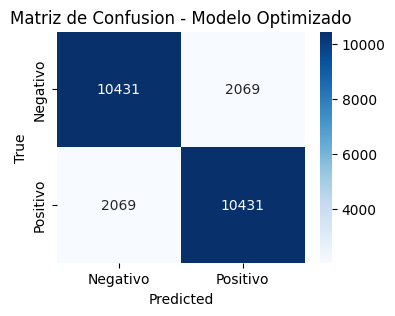

In [199]:
y_pred2 = [1 if p >=0.5 else 0 for p in y_pred2]

cm2 = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(4,3))
plt.title("Matriz de Confusion - Modelo Optimizado")
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negativo","Positivo"],
            yticklabels=["Negativo","Positivo"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()